Face-tracing algorithm
=========================

Problem: given a set of lines, identify all closed regions (subshapes).

In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Loads our helper module built for this exercise

In [7]:
import hestus
from importlib import reload

In [118]:
reload(hestus)

<module 'hestus' from '/Users/nemmen/Library/CloudStorage/Dropbox/codes/jupyter/projects/hestus-problem/hestus.py'>

In [14]:
import networkx as nx

## Trial shapes

In [4]:
square = (
    ((1, 1), (1, 2)),
    ((1, 2), (2, 2)),
    ((2, 2), (2, 1)),
    ((2, 1), (1, 1)),
)

In [3]:
hourglass=( ((1, 1), (1, 2)),
((1, 2), (2, 1)),
((2, 1), (2, 2)),
((2, 2), (1, 1)), )

In [5]:
window= ( ((1, 1), (1, 2)),
((1, 2), (2, 2)),
((2, 2), (2, 1)),
((2, 1), (1, 1)),
((1.5, 1), (1.5, 2)),
((1, 1.5), (2, 1.5)), )

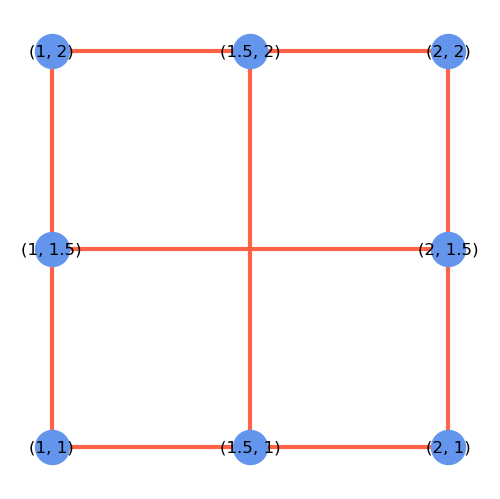

In [119]:
hestus.plot(window)

## Playing with graphs

create an undirected graph and load the edges

In [ ]:
G = nx.Graph()
G.add_edges_from(window)

some basic operations

In [ ]:
print(f"|V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

|V|=8, |E|=6


In [20]:
print("nodes:", G.nodes())
print("edges:", G.edges())

degree of (1,1): 2
connected? False
nodes: [(1, 1), (1, 2), (2, 2), (2, 1), (1.5, 1), (1.5, 2), (1, 1.5), (2, 1.5)]
edges: [((1, 1), (1, 2)), ((1, 1), (2, 1)), ((1, 2), (2, 2)), ((2, 2), (2, 1)), ((1.5, 1), (1.5, 2)), ((1, 1.5), (2, 1.5))]


### Basic operations on a node

In [ ]:
print("degree of (1,1):", G.degree((1,1)))          

Dict of neighbors of a node

In [24]:
G.adj[(1,1)]

AtlasView({(1, 2): {}, (2, 1): {}})

Edges connected to a given node

In [27]:
G.edges((1,1))

EdgeDataView([((1, 1), (1, 2)), ((1, 1), (2, 1))])

### Simple cycle detection

In [32]:
cycles=nx.cycle_basis(G)

In [33]:
print(cycles)

[[(2, 2), (1, 2), (1, 1), (2, 1)]]


In [31]:
print("contains cycle?", bool(nx.cycle_basis(G)))

contains cycle? True


## Algorithm outline

Our eyes immediately realize the intersections between lines and the geometrical "subshapes" they form, but the computer has no idea about them. We need to use geometry to teach the computer to identify these shapes. There are three basic steps.

1. Find intersections between lines✅
2. Establish new edges in addition to those of the original shape
3. Identify closed regions

Below I will break down steps 1 to 3.

## (1) Find intersections

### Find intersecting point between two lines

In [90]:
def find_intersection(l1, l2):
    """
    Return (xi, yi) where (xi, yi) is the intersection of the
    infinite lines through p1-p2 and p3-p4.
    Input: each point is a pair (x, y).
    """
    (x1, y1), (x2, y2) = l1
    (x3, y3), (x4, y4) = l2

    denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    if denom == 0:            # parallel or coincident
        return None, None

    c1 = x1*y2 - y1*x2
    c2 = x3*y4 - y3*x4

    xi = (c1*(x3 - x4) - (x1 - x2)*c2) / denom
    yi = (c1*(y3 - y4) - (y1 - y2)*c2) / denom

    # parameters for the two segments
    t = ((x3 - x1)*(y3 - y4) - (y3 - y1)*(x3 - x4)) / denom
    u = ((x3 - x1)*(y1 - y2) - (y3 - y1)*(x1 - x2)) / denom

    return (xi, yi)

In [80]:
find_intersection(((1, 1), (1, 2)),((1.5, 1), (1.5, 2)))

(None, None)

In [82]:
find_intersection(((1, 1), (1, 2)),((1, 1.5), (2, 1.5)))

(1.0, 1.5)

### Find all intersections in graph

In [96]:
intersections=set()

for e in G.edges():
    for f in G.edges():
        # avoid the same vertex
        if e!=f:
            inter=find_intersection(e,f)
            if None not in inter:
                intersections.add(inter)

In [97]:
intersections

{(1.0, 1.0),
 (1.0, 1.5),
 (1.0, 2.0),
 (1.5, 1.0),
 (1.5, 1.5),
 (1.5, 2.0),
 (2.0, 1.0),
 (2.0, 1.5),
 (2.0, 2.0)}

In [98]:
len(intersections)

9

## Establish new segments

Fully connected graph, with all possible connections between nodes

In [99]:
FG = nx.complete_graph(intersections)   # undirected by default

In [101]:
FG.number_of_edges()

36

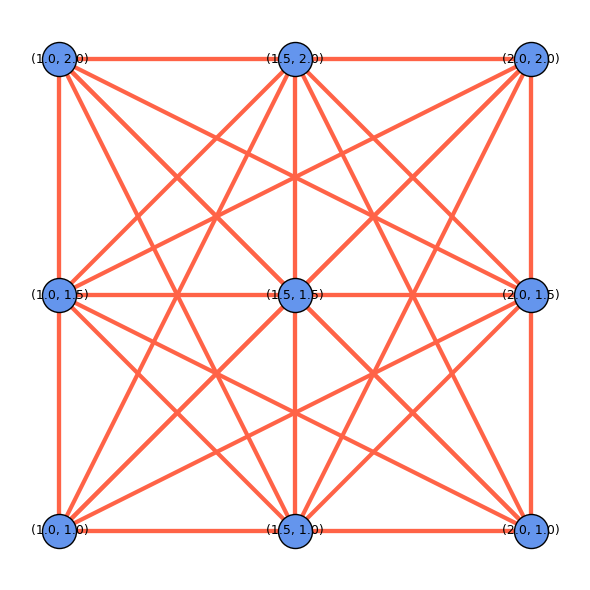

In [120]:
hestus.plot_graph(FG)

### Test parallel lines finder

Discard those that are not parallel to pre-existing lines

In [102]:
FG.edges()

EdgeView([((1.0, 2.0), (1.5, 1.0)), ((1.0, 2.0), (2.0, 1.0)), ((1.0, 2.0), (2.0, 1.5)), ((1.0, 2.0), (1.5, 1.5)), ((1.0, 2.0), (1.0, 1.5)), ((1.0, 2.0), (1.0, 1.0)), ((1.0, 2.0), (2.0, 2.0)), ((1.0, 2.0), (1.5, 2.0)), ((1.5, 1.0), (2.0, 1.0)), ((1.5, 1.0), (2.0, 1.5)), ((1.5, 1.0), (1.5, 1.5)), ((1.5, 1.0), (1.0, 1.5)), ((1.5, 1.0), (1.0, 1.0)), ((1.5, 1.0), (2.0, 2.0)), ((1.5, 1.0), (1.5, 2.0)), ((2.0, 1.0), (2.0, 1.5)), ((2.0, 1.0), (1.5, 1.5)), ((2.0, 1.0), (1.0, 1.5)), ((2.0, 1.0), (1.0, 1.0)), ((2.0, 1.0), (2.0, 2.0)), ((2.0, 1.0), (1.5, 2.0)), ((2.0, 1.5), (1.5, 1.5)), ((2.0, 1.5), (1.0, 1.5)), ((2.0, 1.5), (1.0, 1.0)), ((2.0, 1.5), (2.0, 2.0)), ((2.0, 1.5), (1.5, 2.0)), ((1.5, 1.5), (1.0, 1.5)), ((1.5, 1.5), (1.0, 1.0)), ((1.5, 1.5), (2.0, 2.0)), ((1.5, 1.5), (1.5, 2.0)), ((1.0, 1.5), (1.0, 1.0)), ((1.0, 1.5), (2.0, 2.0)), ((1.0, 1.5), (1.5, 2.0)), ((1.0, 1.0), (2.0, 2.0)), ((1.0, 1.0), (1.5, 2.0)), ((2.0, 2.0), (1.5, 2.0))])

In [106]:
from math import hypot

def are_parallel(l1, l2, tol=1e-9):
    """
    Return True if the (infinite) lines defined by the two point pairs are parallel.
    """
    (x1, y1), (x2, y2) = l1
    (x3, y3), (x4, y4) = l2

    # Direction vectors
    v1x, v1y = x2 - x1, y2 - y1
    v2x, v2y = x4 - x3, y4 - y3

    # Guard against zero-length lines
    if v1x == v1y == 0 or v2x == v2y == 0:
        raise ValueError("At least one line has zero length (two identical end-points).")

    # 2-D cross product
    cross = v1x * v2y - v1y * v2x

    # Scale tolerance with the largest direction-vector magnitude so that
    # the test is invariant to coordinate scale.
    scale = max(hypot(v1x, v1y), hypot(v2x, v2y))
    return abs(cross) <= tol * scale

In [104]:
are_parallel(((1, 1), (1, 2)),((1.5, 1), (1.5, 2)))

True

In [105]:
are_parallel(((1, 1), (1, 2)),((1, 1.5), (2, 1.5)))

False

### Discard all lines which are not parallel to existing ones

Build a list of edges to delete

In [107]:
for e in FG.edges():
    if not are_parallel(e, )

((1.0, 2.0), (1.5, 1.0))
((1.0, 2.0), (2.0, 1.0))
((1.0, 2.0), (2.0, 1.5))
((1.0, 2.0), (1.5, 1.5))
((1.0, 2.0), (1.0, 1.5))
((1.0, 2.0), (1.0, 1.0))
((1.0, 2.0), (2.0, 2.0))
((1.0, 2.0), (1.5, 2.0))
((1.5, 1.0), (2.0, 1.0))
((1.5, 1.0), (2.0, 1.5))
((1.5, 1.0), (1.5, 1.5))
((1.5, 1.0), (1.0, 1.5))
((1.5, 1.0), (1.0, 1.0))
((1.5, 1.0), (2.0, 2.0))
((1.5, 1.0), (1.5, 2.0))
((2.0, 1.0), (2.0, 1.5))
((2.0, 1.0), (1.5, 1.5))
((2.0, 1.0), (1.0, 1.5))
((2.0, 1.0), (1.0, 1.0))
((2.0, 1.0), (2.0, 2.0))
((2.0, 1.0), (1.5, 2.0))
((2.0, 1.5), (1.5, 1.5))
((2.0, 1.5), (1.0, 1.5))
((2.0, 1.5), (1.0, 1.0))
((2.0, 1.5), (2.0, 2.0))
((2.0, 1.5), (1.5, 2.0))
((1.5, 1.5), (1.0, 1.5))
((1.5, 1.5), (1.0, 1.0))
((1.5, 1.5), (2.0, 2.0))
((1.5, 1.5), (1.5, 2.0))
((1.0, 1.5), (1.0, 1.0))
((1.0, 1.5), (2.0, 2.0))
((1.0, 1.5), (1.5, 2.0))
((1.0, 1.0), (2.0, 2.0))
((1.0, 1.0), (1.5, 2.0))
((2.0, 2.0), (1.5, 2.0))
